# Präsenzversuch zum Laval-Rotor

Name:   Young-Min Kong

Datum:  24.01.2024

Gruppe: 12

## Forschungsfrage

Inwiefern stimmen die analytisch berechneten kritischen Drehzahlen mit den experimentell ermittelten Werten überein, und welche Schlüsse lassen sich daraus für die Anwendbarkeit der Theorie auf reale Systeme ziehen?

## Erster Versuch: Prüfstand #03
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="images/lavalrotor.jpg" width="500">

Die zentrale Welle bildet das Grundgerüst des Prüfstands und dient als Träger für die Rotorscheibe. Die Länge der Welle ist relevant für die Berechnungen der auf die Wellenlänge bezogenen Abstände.
Rotorscheibe:

Die Rotorscheibe ist das rotierende Element des Prüfstands. In diesem Fall handelt es sich um eine einzelne Scheibe. Die Scheibe ist symmetrisch an der Welle angebracht und hat ein Gewicht von 950 Gramm. Die Gewichtsverteilung und -symmetrie beeinflussen die Schwingungen und die kritische Drehzahl des Rotors.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240123_140859_lavalrotor_12_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240123_140859_lavalrotor_12_03.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240123_140859_lavalrotor_12_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240123_140859_lavalrotor_12_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240123_140859_lavalrotor_12_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240123_140859_lavalrotor_12_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [5]:
# init
campbell_data = {
    'rpm': [],
    'acceleration': [],
    'fft': []
}

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
# Extracting and processing the data for Campbell diagram
for group in range(0, 20):
    group_path = f"{group}/RawData/{uuid_motor_rpm}/motor_rpm"
    timestamp_path = f"{group}/RawData/{uuid_acceleration}/timestamp"
    accel_x_path = f"{group}/RawData/{uuid_acceleration}/acceleration_x"
    accel_y_path = f"{group}/RawData/{uuid_acceleration}/acceleration_y"
    accel_z_path = f"{group}/RawData/{uuid_acceleration}/acceleration_z"
    
    with h5py.File(path_measurement_folder + "/" + filename, 'r') as h5_file:
        # Extracting data
        rpm = h5_file[group_path][()]
        timestamp = h5_file[timestamp_path][:]
        accel_x = h5_file[accel_x_path][:]
        accel_y = h5_file[accel_y_path][:]
        accel_z = h5_file[accel_z_path][:]

        # Calculating acceleration magnitude
        #accel_magnitude = m_postprocessing.get_vec_accel(accel_x, accel_y, accel_z)
        accel_magnitude = m_postprocessing.get_vec_accel(accel_x,accel_y,accel_z)

        # Interpolating acceleration data to match the interpolation points
        interpolated_accel = m_postprocessing.interpolation(timestamp, accel_magnitude, interpolation_points)
        
        # Use FFT on acceleration data
        fft_accel = m_postprocessing.my_fft_scaled(interpolated_accel, interpolation_points)

        # Storing data in the structure
        campbell_data['rpm'].append(rpm)
        campbell_data['acceleration'].append(interpolated_accel)
        campbell_data['fft'].append(fft_accel)

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

1220


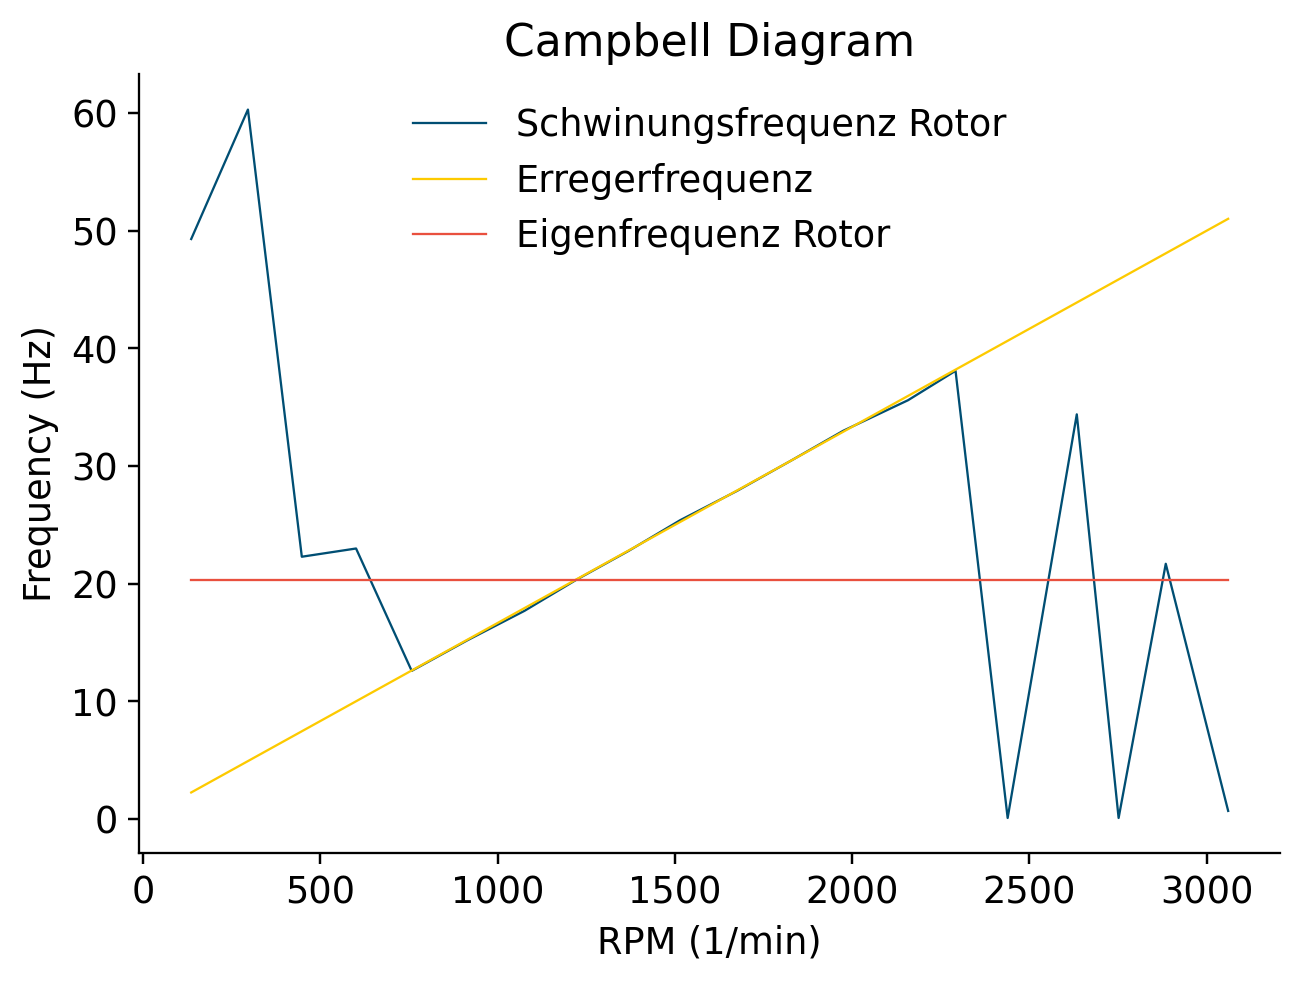

In [7]:
fft = campbell_data['fft']
rpm = np.array(campbell_data['rpm'])
freq_from_rpm = rpm / 60

peaks = [np.max(f[0][1:]) for f in fft]
freqs = [f[1][1:][np.argmax(f[0][1:])] for f in fft]

# critical frequency is when the peak is the highest
max_freq = max(peaks)
max_index = peaks.index(max_freq)
crit_rpm = rpm[max_index]
print(crit_rpm)
crit_freq = crit_rpm/60

plt.plot(rpm, freqs, label = 'Schwinungsfrequenz Rotor')
plt.plot(rpm, freq_from_rpm, label = 'Erregerfrequenz')
plt.plot(rpm, [crit_freq]*len(rpm), label = 'Eigenfrequenz Rotor')

plt.xlabel('RPM (1/min)')
plt.ylabel('Frequency (Hz)')
plt.title('Campbell Diagram')

plt.legend()
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die experimentiell bestimmte kritische Drehzahl liegt bei etwa 1220 1/min. Die analytische berechnete kritische Drehzahl ist 1061.04 1/min. Der Fehler liegt bei 1220/1061.04 = 1.15, also bei etwa 15 Prozent. 

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Analytische Berechnung:
$$
n_{\text{krit}} = \frac{1}{2\pi} \cdot \omega_{\text{krit}} = 17.6837 \, \frac{Umdrehungen}{s} = 1061.04 \, \frac{1}{min}\\
\text{mit}\\
\omega_{krit} = \sqrt{\frac{k}{m}} = \sqrt{\frac{3}{4} \cdot \frac{E \pi D^4}{m l^3}} = 111.11 \frac{1}{s}\\\text{und}\\
k = \frac{3EI}{(0.5l)^4} \cdot l = \frac{48EI}{l^3} \cdot \frac{\pi}{64} \cdot D^4 = \frac{3}{4} \frac{E \pi D^4}{l^3} = 11.7286 \, \frac{N}{min}\\\text{und}\\
I = \frac{\pi}{64} \cdot D^4
$$

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Die Diskrepanz zwischen experimentellen und analytischen Ergebnissen unterstreicht die Notwendigkeit einer kontinuierlichen Verbesserung und Anpassung theoretischer Modelle.
Zusätzliche Parameter oder Effekte könnten in zukünftigen Modellierungsansätzen berücksichtigt werden, um die Genauigkeit zu steigern.
Mögliche Einschränkungen in der experimentellen Apparatur und Messtechnik könnten zu Ungenauigkeiten führen. Eine genaue Kalibrierung der Messinstrumente könnte die experimentelle Genauigkeit verbessern.
Insgesamt verdeutlichen die Experimente die Komplexität der Dynamik von Rotorsystemen und die Notwendigkeit einer fortlaufenden Optimierung von theoretischen Modellen und experimentellen Methoden. 